In [150]:
import pandas as pd
import numpy as np
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Support functions

In [39]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

In [40]:
# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

### Transforming drawings to Fourier descriptors

**Single file**

In [100]:
directory = "drawings/normal/"
filepath = directory + "stisnjena3.csv"
df = pd.read_csv(filepath)
df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
df['x'] = df['x'] - df['x'].iloc[0]
df['y'] = df['y'] - df['y'].iloc[0]

M = 100 # Number of points to resample to
g = resample_trajectory(list(zip(df['x'], df['y'])), M)

In [103]:
Z = fourier_descriptor_transform(g)
g_reconst = inverse_fourier_descriptor_transform(Z)

In [67]:
g_rec_df = pd.DataFrame.from_dict(g_reconst, orient='index', columns=['x', 'y'])
g_rec_df.to_csv(directory + "stisn_rec_" + str(M) + '_test' + '.csv', index=False)

**Multiple files**

In [145]:
M = 500

directory = "drawings/long/"
# filenames = ["spirala", "stisnjena", "nazobcena", "flat"]
filenames = ["l_spiral", "l_spiky", "l_tight", "l_flat"]

filepaths = [directory + name + f"{i}.csv" for name in filenames for i in range(1,6)]

In [146]:
df_general = pd.DataFrame()

for filepath in filepaths:
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    
    Z = fourier_descriptor_transform(g)
    g_reconst = inverse_fourier_descriptor_transform(Z)

    g_rec_df = pd.DataFrame.from_dict(g_reconst, orient='index', columns=['x', 'y'])
    g_rec_df['dft_real'] = Z.real
    g_rec_df['dft_imag'] = Z.imag
    g_rec_df['original_file'] = os.path.basename(filepath)
    df_general = pd.concat([df_general, g_rec_df], ignore_index=True)

In [147]:
df_general.to_csv(directory + "l_all_dft_reconstructed_" + str(M) + '.csv', index=False)

### PCA analysis

**Option 1 - stacking Re and Im parts**

In [164]:
filepath_pca = "drawings/long/l_all_dft_reconstructed_100.csv"
df_pca = pd.read_csv(filepath_pca)

df_pca.head()

,x,y,dft_real,dft_imag,original_file
0,4.547474e-15,0.000000,4.550009,8.313603,l_spiral1.csv
1,-2.588555e+00,8.411445,1.213126,6.098878,l_spiral1.csv
2,8.529997e+00,8.470003,0.209896,4.028761,l_spiral1.csv
3,1.718408e+01,0.815918,-0.773007,3.335046,l_spiral1.csv
4,1.528315e+01,-10.716848,-1.148893,3.372153,l_spiral1.csv


In [165]:
# Combining vectors per file and stacking the real and imaginary parts
grouped = df_pca.groupby('original_file')

features_pca = []
features_names = []

for name, group in grouped:
    real_parts = group['dft_real'].values
    imag_parts = group['dft_imag'].values
    feature_vector = np.concatenate([real_parts, imag_parts])
    features_pca.append(feature_vector)
    features_names.append(name)

features_pca = np.array(features_pca)
print(features_pca.shape)

(20, 200)


In [166]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_pca)

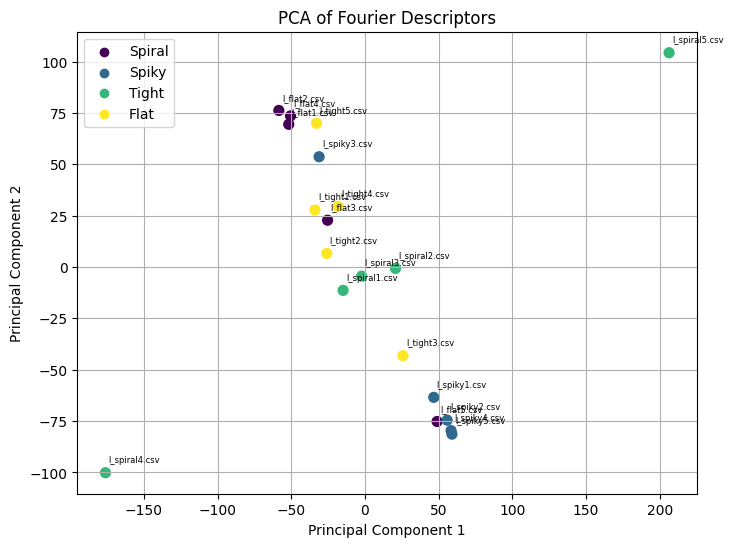

In [167]:
labels = 5*[0] + 5*[1] + 5*[2] + 5*[3]
labels_dic = {0: 'Spiral', 1: 'Spiky', 2: 'Tight', 3: 'Flat'}

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=50)
plt.title('PCA of Fourier Descriptors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Point annotation
for i, name in enumerate(features_names):
    plt.annotate(name, (X_pca[i,0]+2, X_pca[i,1]+5), fontsize=6)

for i in np.unique(labels):
    plt.scatter([], [], color=scatter.cmap(scatter.norm(i)), label=f"{labels_dic[i]}")
plt.legend()
plt.grid()
plt.show()

Plot spiral of interest:

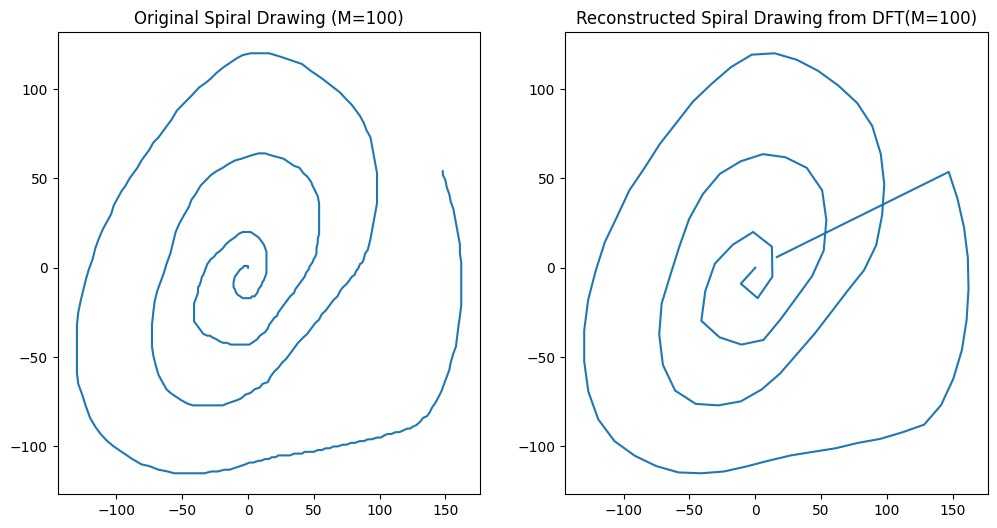

In [169]:
spiral = "l_flat3.csv"
spiral_path = directory + spiral

df_spiral = pd.read_csv(spiral_path)
df_spiral.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
df_spiral['x'] = df_spiral['x'] - df_spiral['x'].iloc[0]
df_spiral['y'] = df_spiral['y'] - df_spiral['y'].iloc[0]

num_of_desc = features_pca.shape[1] // 2

spiral_idx = features_names.index(spiral)
spiralZ = features_pca[spiral_idx][:num_of_desc] + 1j * features_pca[spiral_idx][num_of_desc:]
g_spiral_reconst = inverse_fourier_descriptor_transform(spiralZ)

ax, fig = plt.subplots(1, 2, figsize=(12,6))
fig[0].set_title(f'Original Spiral Drawing (M={num_of_desc})')
fig[0].plot(df_spiral['x'], df_spiral['y'])
fig[1].set_title(f'Reconstructed Spiral Drawing from DFT(M={num_of_desc})')
fig[1].plot(*zip(*g_spiral_reconst.values()))
plt.show()